# Shifting MNIST dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from augly import image
from multiprocessing import Pool

from sklearn.decomposition import PCA

In [4]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [5]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

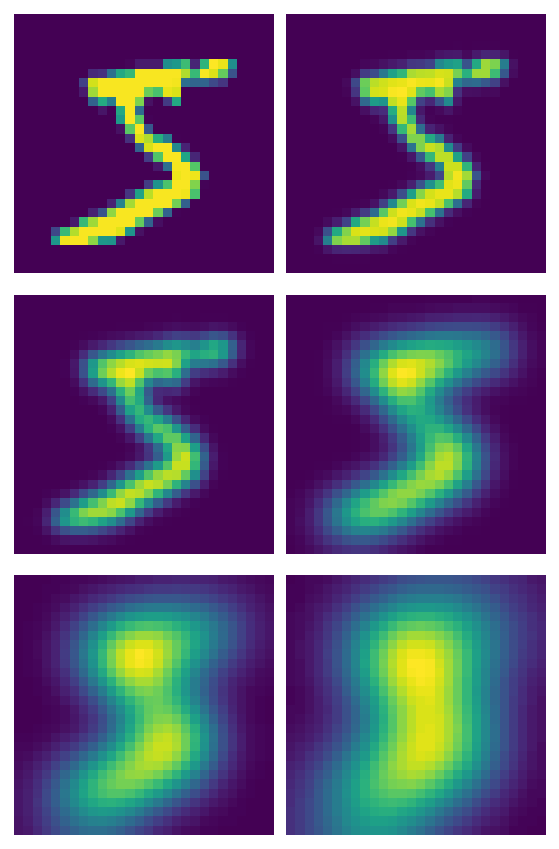

In [7]:
radii = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0]
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(3, 2, figsize=(4, 6))
for axi, radius in zip(ax.flat, radii):
    x_shift = image.aug_np_wrapper(X_train[0], image.blur, radius=radius)
    axi.imshow(x_shift)
    axi.axis("off")
plt.tight_layout()

In [8]:
class BlurRad:
    def __init__(self, rad):
        self.rad = rad
        
    def __call__(self, img):
        return self.blur_multiple(img)

    def blur(self, X):
        """
        Blur an image using the augly library

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        radius: float
            The amout of blurriness
        """
        return image.aug_np_wrapper(X, image.blur, radius=self.rad)

    def blur_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_blur = self.blur(X)
            images_out.append(img_blur)
        images_out = np.stack(images_out, axis=0)
        return images_out

## Estimating weights

In [9]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn # Assuming top-level funciton is jitted
    # return jax.jit(loss_fn) # assuming top-level function is not jitted


class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

    
def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step


def proc_dataset(radius, img_dataset, n_processes=90):
    """
    Blur all images of a dataset stored in a numpy array.
    
    Parameters
    ----------
    radius: float
        Intensity of bluriness
    img_dataset: array(N, L, K)
        N images of size LxK
    n_processes: int
        Number of processes to blur over
    """
    pool = Pool(processes=n_processes)
    
    dataset_proc = np.array_split(img_dataset, n_processes)
    dataset_proc = pool.map(BlurRad(radius), dataset_proc)
    dataset_proc = np.concatenate(dataset_proc, axis=0)
    
    pool.close()
    
    return dataset_proc

In [10]:
key = jax.random.PRNGKey(314)

alpha = 0.001
n_classes = 10
n_subset = 5000
batch_size = 2_000
n_epochs = 150
tx = optax.adam(learning_rate=alpha)

model = MLPWide(n_classes)
# X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
# y_train_ohe = jax.nn.one_hot(y_train, n_classes)


def train_model_config(key, radius, num_epochs):
    X_train_proc = proc_dataset(radius, X_train, 90)
    X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
    y_train_ohe = jax.nn.one_hot(y_train, n_classes)

    batch = jnp.ones((1, 28 ** 2))
    params = model.init(key, batch)
    opt_state = tx.init(params)

    for e in range(num_epochs):
        print(f"@epoch {e+1:03}", end="\r")
        _, key = jax.random.split(key)
        params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

    final_train_acc = (y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean().item()
    print(f"@{rad=:0.4f}, {final_train_acc=:0.4f}")
    
    return params, final_train_acc

In [ ]:
hist_params = []
hist_accuracy = []
radii = jnp.linspace(0.001, 3.00, 100)

time_start = time()
for rad in radii:
    params, train_acc = train_model_config(key, rad, n_epochs)
    
    hist_accuracy.append(train_acc)
    hist_params.append(params)

hist_accuracy = jnp.array(hist_accuracy)
time_end = time()
time_total = time_end - time_start
print(f"Total running time: {time_total:0.2f}s")

In [11]:
filename = "mnist_shift_params.npy"

if os.path.exists(filename):
    hist_params_flat = jnp.load(filename)
else:
    hist_params_flat = dojax.flat_and_concat_params(hist_params)
    jnp.save(filename, hist_params_flat)

In [12]:
hist_params_flat.shape

(100, 1033510)

In [13]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(hist_params_flat)

In [14]:
params_proj.shape

(100, 2)

In [15]:
radii = jnp.linspace(0.001, 3.00, 100)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=radii)
# ax[0].cb(label="radius")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")

ax[1].set_title("Accuracy")
ax[1].scatter(radii, hist_accuracy, c=radii)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy")

In [17]:
pca = PCA(n_components=3)
params_proj = pca.fit_transform(hist_params_flat)

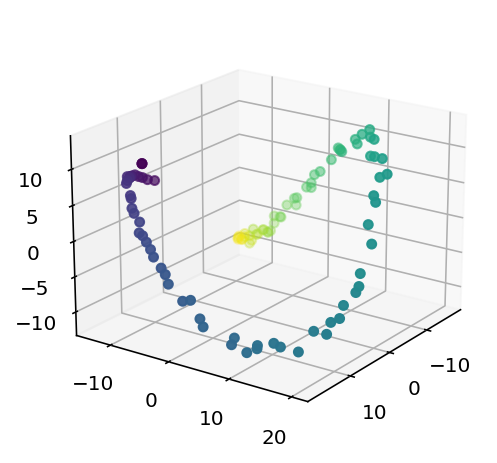

In [18]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.view_init(20, 35)
ax.scatter(*params_proj.T, c=radii)

## Modelling weight dynamics

In [109]:
class MLPWeights(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(200)(x))
        x = nn.Dense(self.num_outputs)(x)
        return x


In [20]:
pca = PCA(n_components=60)
params_proj = pca.fit_transform(hist_params_flat)

In [21]:
params_proj.shape

(100, 60)

### Steps to follow
1. Modify `proc_dataset` so that it takes as input a list of radii and images. Both elements should have the same cardinality over the leading dimension. Its output is a list of images.
2. Modify `make_loss_fn` so that it considers an output in R^d (d-dimensional output with real-valued entries)
3. Modify `get_batch_train_ixs` so that it takes `num_samples` and `num_configs`, where `num_configs` is the total number of configuration. To do this, create a `num_samples x num_configs` count array. Then, given an index `i`, we obtain its config as `i % num_configs`; we obtain its position in the database as `i // num_configs`. Consider the following example:

In [22]:
num_samples = 10
num_configs = 3

samples_ix = jnp.arange(num_samples * num_configs)

In [23]:
# Choose configuration
samples_ix.reshape(num_samples, num_configs) % num_configs

DeviceArray([[0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2]], dtype=int32)

In [24]:
# Choose index
samples_ix.reshape(num_samples, num_configs) // num_configs

DeviceArray([[0, 0, 0],
             [1, 1, 1],
             [2, 2, 2],
             [3, 3, 3],
             [4, 4, 4],
             [5, 5, 5],
             [6, 6, 6],
             [7, 7, 7],
             [8, 8, 8],
             [9, 9, 9]], dtype=int32)

In [25]:
samples_ix[14] // num_configs

DeviceArray(4, dtype=int32)

In [26]:
samples_ix[14] % num_configs

DeviceArray(2, dtype=int32)

4. Modify `train_step` so that it considers the new `make_loss_fn` defined in step `2.`

5. Modify `train_epoch` so that it samples from the indices defined in `3.`. Then, it should return a list of indices to train and radii to try. We modify the input X with the list of radii and obtain our target variable (the weights to predict) given by the list of radii. We then call the modified version of `train_step` (`4.`) with the batch as big as possible (so as to minimise the overhead of computing the transformations of `X`)

### Implementation

https://symbolize.stripped_domain/r/?trace=7ff05034bea7,7ff0501a63bf,563a0a4c547f&map= 
*** SIGTERM received by PID 175193 (TID 175193) on cpu 64 from PID 173448; stack trace: ***
https://symbolize.stripped_domain/r/?trace=563a0a2bd7cb,7ff0501a63bf&map= 
*** SIGTERM received by PID 175194 (TID 175194) on cpu 95 from PID 173448; stack trace: ***
PC: @     0x7ff05034bea7  (unknown)  operator delete[]()
    @     0x7ff03fa527fa        992  (unknown)
    @     0x7ff0501a63c0  388168272  (unknown)
PC: @     0x563a0a2bd7cb  (unknown)  _PyFunction_Vectorcall
    @     0x7ff03fa527fa        992  (unknown)
    @     0x7ff0501a63c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=563a0a2bd7cb,7ff03fa527f9,7ff0501a63bf&map=7a511a57244151c993b16b37978e7ed7:7ff03107a000-7ff03fdbcd50 
E0224 06:21:19.024504  175194 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
    @     0x563a0a4c5480  (unknown)  (unknown)
https://symboliz

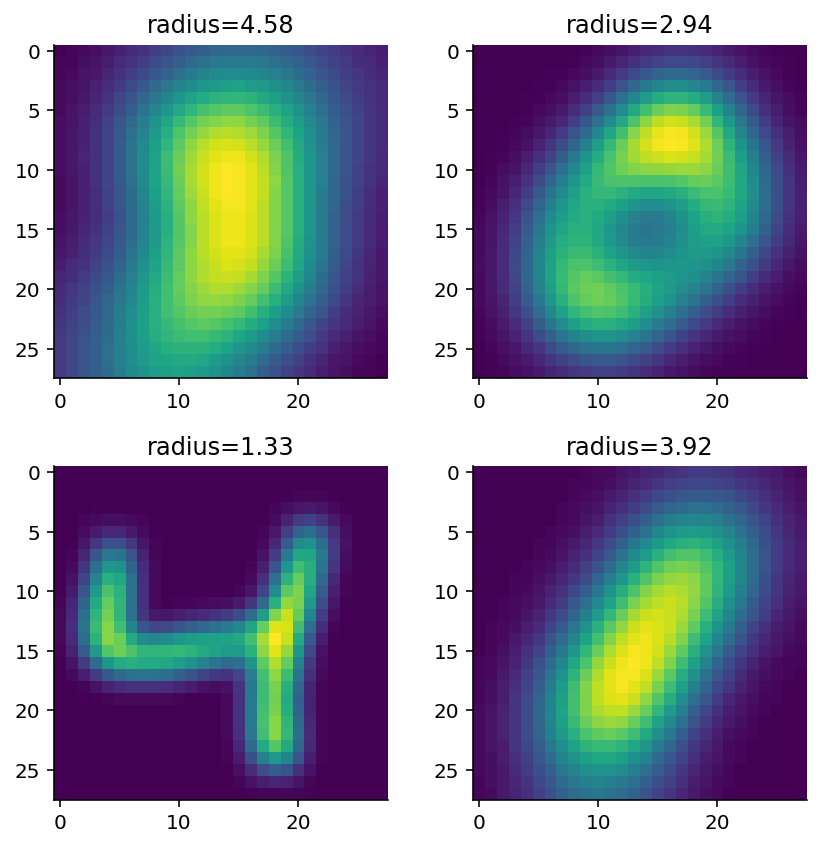

In [27]:
size_subset = 4
n_processes = 4

np.random.seed(314)
radii = np.random.rand(size_subset) * 5

X_train_subset = X_train[:size_subset, ...]
X_train_subset.shape

res = dojax.proc_dataset_multiple(radii, X_train_subset, n_processes)

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
for radius, axi, img in zip(radii, ax.flat, res):
    axi.imshow(img)
    axi.set_title(f"{radius=:0.2f}")
plt.tight_layout()

## Loss function for multiple outputs

$$
    \mathcal{L} = \frac{1}{2N}\sum_{n=1}^N \vert\vert {\bf y}_n - {\bf W}^T\phi({\bf x}_n) \vert\vert^2
$$

In [28]:
def make_loss_func_multiple(model, X, y):
    """
    Loss function for regression problem with multiple outputs
    """
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = jnp.linalg.norm(y_test - y_hat, axis=-1) ** 2
        return loss.mean()
    return loss_fn

In [110]:
weight_model = MLPWeights(10)

In [30]:
batch = jnp.ones((1, 28 ** 2))
params = weight_model.init(key, batch)
opt_state = tx.init(params)

In [31]:
y_test = jax.random.normal(key, (4, 10)) * 10
y_hat = weight_model.apply(params, res.reshape(4, -1))

### Getting training indices


In [73]:
def get_batch_train_configs_ixs(num_samples, num_configs, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation
    
    We consider a tranining dataset over number of samples and
    number of configurtios.
    """
    num_elements = num_samples * num_configs
    
    steps_per_epoch = num_elements // batch_size
    
    # Maybe we can only use numpy here to avoid sending /
    # calling elements from the TPU
    # batch_ixs = jax.random.permutation(key, num_elements)
    batch_ixs = np.random.permutation(num_elements)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    batch_ixs_samples = batch_ixs // num_configs
    batch_ixs_configs = batch_ixs % num_configs
    
    return batch_ixs_samples, batch_ixs_configs

### The new training step

In [116]:
n_configs, dim_params = params_proj.shape
weight_model = MLPWeights(dim_params)

In [117]:
@jax.jit
def train_step_weights(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func_multiple(weight_model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params

### New training episode

In [145]:
size_subset = 500
X_train_subset = X_train[:size_subset, ...]

X_train_subset.shape

(500, 28, 28)

In [146]:
n_configs, dim_params = params_proj.shape
print(n_configs)

100


In [147]:
format(500 * 100, ",")

'50,000'

In [148]:
np.random.seed(314)
batch_size = 100
sample_ixs, config_ixs = get_batch_train_configs_ixs(size_subset, n_configs, batch_size)

In [149]:
sample_batch_ix = sample_ixs[0]
config_batch_ix = config_ixs[0]

In [150]:
X_batch = X_train_subset[sample_batch_ix, ...]
weights_batch = params_proj[config_batch_ix, ...]

In [151]:
params_proj.shape

(100, 60)

In [152]:
n_processes = 20
radii = jnp.linspace(0.001, 3.00, 100)

weight_model = MLPWeights(dim_params)
batch = jnp.ones((1, 28 ** 2))
params = weight_model.init(key, batch)
opt_state = tx.init(params)

config_batch = radii[config_batch_ix]
X_batch_transformed = dojax.proc_dataset_multiple(config_batch, X_batch, min(n_processes, batch_size))
X_batch_transformed = X_batch_transformed.reshape(-1, 28 ** 2)

_ = train_step_weights(params, opt_state, X_batch_transformed, weights_batch)

In [163]:
def train_epoch_weights(key, params, opt_step, X, configs, target_weights, batch_size, epoch):
    """
    Training epoch for the projected weights. Note that target weights are the
    target variables
    """
    num_samples = len(X)
    num_configs = len(target_weights)
    
    sample_ixs, config_ixs = get_batch_train_configs_ixs(num_samples, num_configs,
                                                         batch_size)
    
    n_processes_batch = min(n_processes, batch_size)
    for (sample_batch_ix, config_batch_ix) in zip(sample_ixs, config_ixs):
        X_batch = X[sample_batch_ix, ...]
        config_batch = configs[config_batch_ix]
        X_batch_transformed = dojax.proc_dataset_multiple(config_batch, X_batch, n_processes_batch).reshape(-1, 28 ** 2)
        
        weights_batch = target_weights[config_batch_ix, ...]
        loss, params = train_step_weights(params, opt_step, X_batch_transformed, weights_batch)
        
    return params, opt_step


In [ ]:
train_epoch_weights(key, params, opt_state, X_train_subset, radii, params_proj, 100, 0)